Using [ULMFiT](https://arxiv.org/abs/1801.06146) with fastai:

- Take a language model (LM) pre-trained on a large general domain corpus, in this case an AWD-LSTM trained on WikiText-103
- Fine-tune the LM on the task text (train and test) using the various fastai training tricks including traingular slanted learning rates
- Further fine-tune on the classification task using gradual unfreezing of layers


In [1]:
## libraries
import numpy as np
import pandas as pd
from fastai.text import *
from pathlib import Path
np.random.seed(20)

In [ ]:
# from IPython.display import FileLink

# FileLink(r'fit_head')

In [ ]:
# ## create directory and path for models
# if not os.path.isdir('/kaggle/working/'):
#     os.makedirs('/kaggle/working/')
    
# path_model = Path("/kaggle/working/")

In [59]:
## read in datasets
trainOld = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train = pd.read_csv('../input/realornot-cleanedtrain/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [63]:
# merged = trainOld.merge(train, indicator=True, how='outer')
merged[merged['_merge'] == 'left_only']


,id,keyword,location,text,target,_merge
229,328,annihilated,NaN,Ready to get annihilated for the BUCS game,1,left_only
301,443,apocalypse,NaN,Short Reading\n\nApocalypse 21:1023 \n\nIn the...,1,left_only
356,513,army,Studio,But if you build an army of 100 dogs and their...,1,left_only
1822,2619,crashed,NaN,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,1,left_only
2457,3525,derailment,UK,@Raishimi33 :) well I think that sounds like a...,1,left_only
2536,3640,desolation,"Quilmes , Arg",This desperation dislocation\nSeparation conde...,1,left_only
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1,left_only
2851,4097,displaced,United Kingdom,For those displaced by disasters label and leg...,0,left_only
3024,4342,dust%20storm,chicago,Going to a fest? Bring swimming goggles for th...,1,left_only
3226,4630,emergency%20services,"Whippany, NJ",Air Group is here to the rescue! We have 24/7 ...,0,left_only


In [7]:
!pwd
!ls ../input

/kaggle/working
nlp-getting-started  realornot	realornot-cleanedtrain


In [9]:
# Additional train data from external source
# https://crisisnlp.qcri.org/lrec2016/lrec2016.html
ex1 = pd.read_csv('../input/realornot/1.tsv', sep='\t')
ex2 = pd.read_csv('../input/realornot/2.tsv', sep='\t')
ex3 = pd.read_csv('../input/realornot/3.tsv', sep='\t')
ex4 = pd.read_csv('../input/realornot/4.tsv', sep='\t')
ex5 = pd.read_csv('../input/realornot/5.tsv', sep='\t')
ex6 = pd.read_csv('../input/realornot/6.tsv', sep='\t')
ex7 = pd.read_csv('../input/realornot/7.tsv', sep='\t')
ex8 = pd.read_csv('../input/realornot/8.tsv', sep='\t')
ex9 = pd.read_csv('../input/realornot/9.tsv', sep='\t')
ex10 = pd.read_csv('../input/realornot/10.tsv', sep='\t')

In [13]:
ex1.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex2.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex3.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex4.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex5.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex6.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex7.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex8.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex9.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)
ex10.rename(columns={"tweet_id":"id", "tweet_text": "text", "label": "target"}, inplace=True)

ex1.insert(1,"keyword",""); ex1.insert(2,"location","")
ex2.insert(1,"keyword",""); ex2.insert(2,"location","")
ex3.insert(1,"keyword",""); ex3.insert(2,"location","")
ex4.insert(1,"keyword",""); ex4.insert(2,"location","")
ex5.insert(1,"keyword",""); ex5.insert(2,"location","")
ex6.insert(1,"keyword",""); ex6.insert(2,"location","")
ex7.insert(1,"keyword",""); ex7.insert(2,"location","")
ex8.insert(1,"keyword",""); ex8.insert(2,"location","")
ex9.insert(1,"keyword",""); ex9.insert(2,"location","")
ex10.insert(1,"keyword",""); ex10.insert(2,"location","")

In [18]:
ex = pd.concat([ex1[:1000],ex2[:1000],ex3[:1000],ex4[:1000],ex5[:1000],ex6[:1000],ex7[:1000],ex8[:1000],ex9[:1000],ex10[:1000]])

In [26]:
ex['target'] = (ex['target'] != 'not_related_or_irrelevant').astype(int)

In [27]:
ex[:20]

,id,keyword,location,text,target
0,'504075795435094016',,,"Bridges, overpasses earn approval after Northe...",1
1,'503765744333901824',,,"Say what you want, but the earthquake that hit...",1
2,'503741064067313665',,,Cool data analysis of today's Napa earthquake ...,1
3,'503910039715725312',,,California assessing damage after large quake ...,1
4,'503892224589848576',,,RT @heyyouapp: California USA Rancho Cucamonga...,1
5,'503653968279793664',,,RT @GoodBelly: California Winemakers Cleaning ...,1
6,'504668324777967616',,,"RT @friend_beast: Oh, California RT @vickydngu...",1
7,'503712067942350849',,,→ USA → California Hit With Earthquake Of 6.0...,1
8,'503662312923086848',,,RT @Zamaanie: Zionist US supplies Israel with ...,0
9,'503649259577569280',,,"RT @The_New_Rome: Still, we find beauty (&amp;...",1


In [29]:
## create databunch with both train and test text and label for language model
bs = 64
data_lm = (TextList.from_df(pd.concat([train[['text']], test[['text']], ex[['text']]], ignore_index=True, axis=0))
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs))

In [30]:
## check tokenisation looks ok on training set
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos xxmaj just got sent this photo from xxmaj ruby # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj
1,xxunk xxbos xxup xxunk xxmaj xxunk xxmaj xxunk xxmaj dial xxmaj army xxmaj xxunk xxmaj quartz xxmaj xxunk xxmaj watch xxmaj sport xxmaj blue xxmaj nylon xxmaj fabric - xxmaj full reaû _ http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj one xxmaj direction xxmaj is my pick for http : / / t.co / q2eblokeve xxmaj fan xxmaj army # xxmaj
2,bleeding xxbos xxmaj apparently if you 're bleeding people look at you weird lol well it 's fine keep walking xxbos xxmaj eating xxunk then xxunk my eyes with my hands now my eyes are bleeding tears xxbos xxunk yea heard about that .. not coming out until xxunk and xxunk xxrep 6 ? xxmaj vampiro is bleeding xxbos xxunk xxmaj did that look broken or bleeding ? xxbos i
3,t.co / xxunk via xxunk xxbos @whitehouse xxup @potus xxmaj just cos xxmaj germany invaded xxmaj poland xxmaj japan bombed xxmaj xxunk xxmaj harbor xxup pre - xxup xxunk xxup suicide http : / / t.co / xxunk xxbos xxunk xxunk xxmaj it feels like if i would try to grab one off he s xxmaj xxunk i 'll get bombed . xxbos xxunk xxunk xxunk yeah man xxrep 5
4,xxunk xxup king xxup 's xxup first xxup casualty xxup block xxup me xxup back i xxup hate xxup you ! http : / / t.co / xxunk xxbos xxmaj casualty xxmaj xxunk somebody please am so bored xxbos xxmaj casualty insurance jobs against hunt up xxunk into : xxup xxunk http : / / t.co / xxunk xxbos xxmaj japan had a nuke program ( xxunk xxunk ) and


In [31]:
## create lm learner with pre-trained model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 5.25E-02


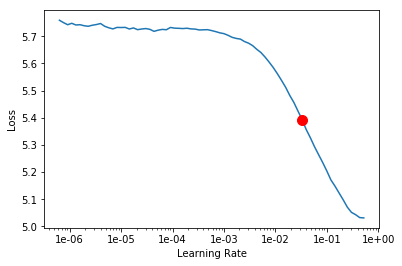

In [32]:
## run lr finder
learn.lr_find()
## plot lr finder
learn.recorder.plot(skip_end=15, suggestion=True)

In [33]:
## train for one epoch frozen
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.497976,3.119029,0.447130,00:12


In [34]:
## train for one epoch frozen
learn.fit_one_cycle(1, 4e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.143689,3.042848,0.458434,00:12


In [35]:
learn.save('/kaggle/working/fit_head')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-04


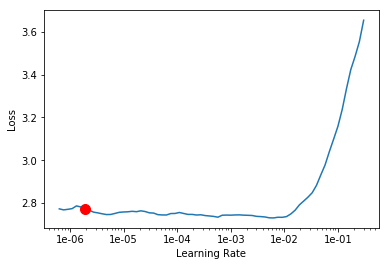

In [36]:
learn.unfreeze()
## run lr finder
learn.lr_find()
## plot lr finder
learn.recorder.plot(skip_end=15, suggestion=True)

In [37]:
## unfreeze and train for four further cycles unfrozen

learn.fit_one_cycle(4, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.667391,2.920205,0.477057,00:16
1,2.486382,2.842203,0.493208,00:16
2,2.060377,2.890233,0.494723,00:16
3,1.619154,2.974098,0.498007,00:16


In [38]:
## save model and encoder
learn.save('/kaggle/working/fine_tuned')
learn.save_encoder('/kaggle/working/fine_tuned_enc')

In [39]:
## training set with text and target
df_train = pd.concat([train[['text', 'target']], ex[['text', 'target']]])

In [40]:
## test set with text
df_test = test[['text']]

In [41]:
## create databunch for classification task, 
## including randomly selected validation set, and test set

bs = 32
data_clas = (TextList.from_df(df_train, vocab=data_lm.vocab)
             #.split_none()
             .split_by_rand_pct(0.2)
             .label_from_df('target')
             .add_test(TextList.from_df(df_test, vocab=data_lm.vocab))
             .databunch(bs=bs))

In [ ]:
## check test set looks ok
data_clas.show_batch(ds_type=DatasetType.Test)

In [42]:
## create classification learning, including f1 score in metrics, and add encoder
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])
learn.load_encoder('/kaggle/working/fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14091 items)
x: TextList
xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj ruby # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires,xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (3522 items)
x: TextList
xxbos xxunk i 'm traumatised,xxbos xxup rt xxunk : xxmaj six questions answered : xxmaj what xxmaj canadians need to know about the xxup mers virus http : / / t.co / xxunk,xxbos xxmaj pray pray pray pray # prayforchile,xxbos xx

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 6.31E-02


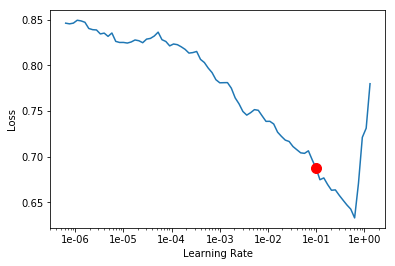

In [43]:
## run lr finder
learn.lr_find()
## plot lr finder
learn.recorder.plot(suggestion=True)

In [44]:
## train for 1 cycle frozen
learn.fit_one_cycle(1, 8e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.423763,0.334409,0.869108,0.903415,00:09


In [46]:
learn.fit_one_cycle(1, 8e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.425470,0.339718,0.863998,0.899686,00:09


In [45]:
learn.save('/kaggle/working/first')

In [47]:
learn.load('/kaggle/working/first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14091 items)
x: TextList
xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj ruby # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires,xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (3522 items)
x: TextList
xxbos xxunk i 'm traumatised,xxbos xxup rt xxunk : xxmaj six questions answered : xxmaj what xxmaj canadians need to know about the xxup mers virus http : / / t.co / xxunk,xxbos xxmaj pray pray pray pray # prayforchile,xxbos xx

In [ ]:
## Data for class interpretation
bs = 32
data_interp = (TextList.from_df(df_train, vocab=data_lm.vocab)
             #.split_none()
             .split_by_rand_pct(0.99)
             .label_from_df('target')
             .add_test(TextList.from_df(df_test, vocab=data_lm.vocab))
             .databunch(bs=bs))

In [ ]:
learn_interp = learn
learn_interp.data = data_interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_interp)

losses,idxs = interp.top_losses()

In [ ]:
losses[:50]

In [ ]:
idxs[:50]

In [ ]:
for i in range(1,50):
    print(interp.data.valid_ds.x[idxs[i]])

In [ ]:
interp.data.valid_ds.y[4748]

In [ ]:
[1,0,]

In [ ]:
!cp '/kaggle/input/nlp-getting-started/train.csv' '/kaggle/working/'

In [48]:
## unfreeze the last 2 layers and train for 1 cycle
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(6e-2/(2.6**4),6e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.367426,0.294923,0.880466,0.912782,00:10


In [49]:
learn.save('/kaggle/working/second')

In [50]:
## unfreeze the last 3 layers and train for 1 cycle
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.302601,0.397973,0.886428,0.916528,00:14


In [51]:
learn.save('/kaggle/working/third')

In [52]:
## unfreeze all and train for 2 cycles
learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.291397,0.282629,0.889835,0.918487,00:18
1,0.221675,0.292161,0.886712,0.915591,00:18


In [53]:
learn.save('/kaggle/working/unfz1')

In [ ]:
## unfreeze all and train for 2 cycles
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.load('/kaggle/working/unfz1')

In [54]:
## get test set predictions and ids
preds, _ = learn.get_preds(ds_type=DatasetType.Test,  ordered=True)
preds = preds.argmax(dim=-1)

id = test['id']

In [55]:
my_submission = pd.DataFrame({'id': id, 'target': preds})
my_submission.to_csv('submission.csv', index=False)

In [58]:
learn.predict("the virus party was a blast, ")

(Category 0, tensor(0), tensor([0.8522, 0.1478]))

===========Try BERT==============